In [2]:
source("./libs.R")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

In [4]:
ls()

[1] "cols.BlGy"               "cols.celltype"          
 [3] "cols.cluster"            "cols.hm.avg.tf"         
 [5] "cols.hm.zval.fun"        "cols.hm.zval.fun.2"     
 [7] "cols.sky"                "cols.Spectrum"          
 [9] "cols.subcluster"         "fun.gamSmooth"          
[11] "fun.importRGB"           "fun.plot.project.motif" 
[13] "fun.plt.motif.pt"        "input.chromVar.jaspar.z"
[15] "input.chromVar.res.list" "input.umap.res"         
[17] "Modes"                   "plotColScale"           
[19] "plotLegend"              "theme_pubr"

## 1.Relate ps to motif

In [6]:
input.chromVar.jaspar.z%>%dim
input.chromVar.jaspar.z[1:3,1:3]

[1]   579 15298

,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGTTG,Islet1fresh_AGACACCTAAGAGGCAAAGGCTATATAGA
MA0004.1_Arnt,-1.566904,2.1113089,0.4907512
MA0006.1_Ahr::Arnt,-1.756479,-0.3461105,0.4726955
MA0019.1_Ddit3::Cebpa,-2.644964,-1.1756219,0.8333850


In [10]:
input.chromVar.jaspar.z <- input.chromVar.jaspar.z %>% as.data.frame %>% rownames_to_column("motif") %>% 
    melt(id = "motif", variable.name = "cell", value.name = "zval")
input.chromVar.jaspar.z %>% head(1)
input.chromVar.jaspar.z %>% dim

motif,cell,zval
<chr>,<fct>,<dbl>
MA0004.1_Arnt,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-1.566904


[1] 8857542       3

### 1.2 load ps

In [7]:
input.pseudotime <- fread("../dat/1910_v2/abd.promoter.long_matrix_w_transcripts_ps.txt") %>% 
    select(cell, ps, celltype)%>%distinct
input.pseudotime%>%dim

[1] 14526     3

### 1.3 merge ps to motif result

In [14]:
output.motif.pt <- merge(input.chromVar.jaspar.z, input.pseudotime)
output.motif.pt %>% head(1)
output.motif.pt %>% dim
output.motif.pt %>% select(cell, celltype) %>% distinct %>% pull(celltype) %>% table
output.motif.pt %>% pull(motif) %>% unique %>% length

cell,motif,zval,ps,celltype
<fct>,<chr>,<dbl>,<dbl>,<chr>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha


[1] 8410554       5

.
alpha  beta delta 
 6218  7598   710 

[1] 579

In [18]:
output.motif.pt <- output.motif.pt %>% left_join(input.umap.res %>% rename(cell = "barcodes") %>% 
    select(cell, UMAP1, UMAP2, cluster))
output.motif.pt %>% head(1)
output.motif.pt %>% dim

Joining, by = "cell"
Warning message:
“Column `cell` joining factor and character vector, coercing into character vector”

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha,-5.102393,1.38682,alpha_2


[1] 8410554       8

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


[1] 15298    13

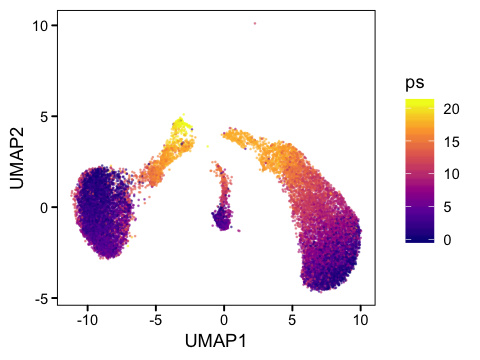

In [42]:
options(repr.plot.width = 4, repr.plot.height = 3)
# filter unkonwn
head(input.umap.res, 1)
dim(input.umap.res)
ggplot(output.motif.pt %>% select(UMAP1, UMAP2, ps) %>% distinct, aes(UMAP1, UMAP2)) + 
    geom_point(aes(color = ps), size = 0.1, alpha = 0.5) + scale_color_viridis_c(option='C') + 
    theme_pubr()
fn <- "../figures/Fig2/subfigs/fig2e.PS_UMAP_qc.pdf"
ggsave(fn, width = 4, height = 3, units = "in", useDingbats = F)
system(paste0("open ", fn))

In [43]:
fread("../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.csv")%>%head(1)

enrichedIn,celltype.label,motif,delta,selected,FDR
<chr>,<chr>,<chr>,<dbl>,<lgl>,<dbl>
alpha_1,alpha (N=180),NEUROD1,1.807373,TRUE,2.200442e-238


In [44]:
dmotifs.list <- sapply(c("alpha", "beta", "delta"), function(x) fread("../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.csv") %>% 
    filter(selected & grepl(x, enrichedIn)) %>% pull(motif))
lapply(dmotifs.list, length)

$alpha
[1] 180

$beta
[1] 80

$delta
[1] 155

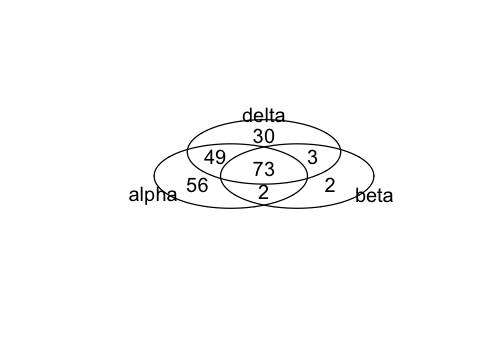

In [47]:
options(repr.plot.width = 4, repr.plot.height = 3)

tmp <- gplots::venn(dmotifs.list)

dmotifs.list.inter <- attr(tmp, "intersections")

In [49]:
dmotifs.list.inter%>%str

List of 7
 $ alpha:beta      : chr [1:2] "NRL" "Mafb"
 $ beta:delta      : chr [1:3] "TEAD1" "HNF1A" "HNF1B"
 $ alpha:delta     : chr [1:49] "STAT3" "Stat4" "FOXA1" "SNAI2" ...
 $ alpha:beta:delta: chr [1:73] "NEUROD1" "Rfx1" "TAL1::TCF3" "ASCL1" ...
 $ beta            : chr [1:2] "MAFG" "PBX2"
 $ alpha           : chr [1:56] "GATA2" "Gata4" "GATA3" "GATA6" ...
 $ delta           : chr [1:30] "Nkx3-1" "ISL2" "NKX3-2" "NFATC1" ...
